In [24]:
# ================================================================
#  AI-Powered Task Management System 
# ================================================================

In [25]:
# -------------------------------
#  1. Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [26]:
# -------------------------------
#  2. Load Dataset
# -------------------------------
df = pd.read_csv("ai_powered_task_management_dataset.csv")
print(" Dataset Loaded Successfully!")
print(df.head())
print(df.info())

 Dataset Loaded Successfully!
   task_id                          task_name assigned_to department priority  \
0        1      Create marketing landing page         Eve    Backend   Medium   
1        2               Update mobile app UI       Grace      UI/UX     High   
2        3            Fix bug in login module      Hannah      UI/UX     High   
3        4  Implement user authentication API       David    Backend     High   
4        5      Improve page load performance      Hannah     DevOps   Medium   

        status created_date    due_date  estimated_hours  actual_hours  \
0  In Progress   04-08-2025  24-08-2025               16           NaN   
1  In Progress   22-06-2025  12-07-2025                7           NaN   
2      Pending   03-05-2025  07-05-2025               12           NaN   
3  In Progress   11-10-2025  15-10-2025                5           NaN   
4    Completed   13-07-2025  03-08-2025               12          11.0   

                                 tags 

In [27]:
# -------------------------------
#  3. Data Cleaning
# -------------------------------
# Remove duplicates & missing values
df.drop_duplicates(inplace=True)
df.dropna(subset=['task_name', 'priority'], inplace=True)

In [28]:
# Convert dates if available
if 'Created Date' in df.columns:
    df['Created Date'] = pd.to_datetime(df['Created Date'], errors='coerce')
if 'Due Date' in df.columns:
    df['Due Date'] = pd.to_datetime(df['Due Date'], errors='coerce')

In [29]:
# Fill missing categorical values
df.fillna({'status': 'Unknown', 'assigned_to': 'Unassigned'}, inplace=True)

print("\n Cleaned Dataset Info:")
print(df.info())


 Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   task_id          5000 non-null   int64  
 1   task_name        5000 non-null   object 
 2   assigned_to      5000 non-null   object 
 3   department       5000 non-null   object 
 4   priority         5000 non-null   object 
 5   status           5000 non-null   object 
 6   created_date     5000 non-null   object 
 7   due_date         5000 non-null   object 
 8   estimated_hours  5000 non-null   int64  
 9   actual_hours     1019 non-null   float64
 10  tags             5000 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 429.8+ KB
None


In [30]:
# -------------------------------
#  4. Exploratory Data Analysis (EDA)
# -------------------------------
print("\n Dataset Summary:")
print(df.describe(include='all'))


 Dataset Summary:
            task_id                      task_name assigned_to department  \
count   5000.000000                           5000        5000       5000   
unique          NaN                             20           8          7   
top             NaN  Create marketing landing page         Eve      UI/UX   
freq            NaN                            291         667        751   
mean    2500.500000                            NaN         NaN        NaN   
std     1443.520003                            NaN         NaN        NaN   
min        1.000000                            NaN         NaN        NaN   
25%     1250.750000                            NaN         NaN        NaN   
50%     2500.500000                            NaN         NaN        NaN   
75%     3750.250000                            NaN         NaN        NaN   
max     5000.000000                            NaN         NaN        NaN   

       priority       status created_date    due_date  e

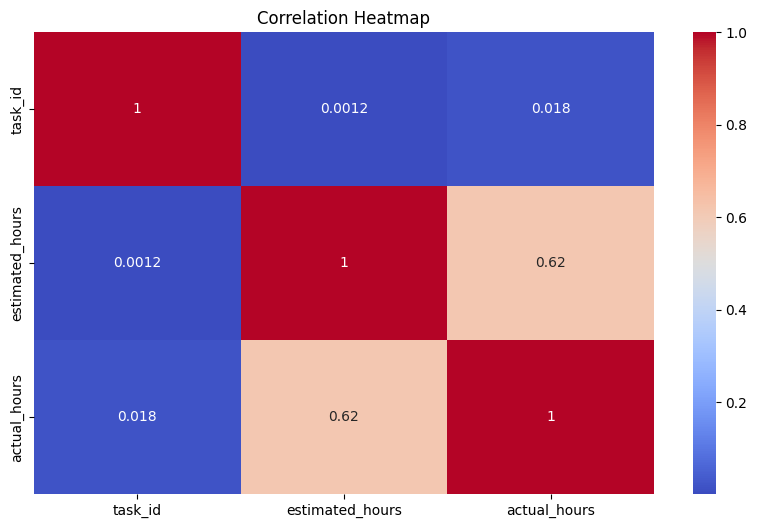

In [31]:
# Correlation heatmap (numerical features only)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

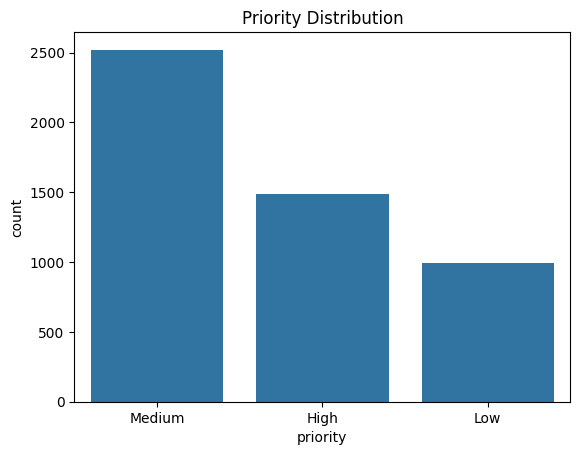

In [32]:
# Priority distribution
sns.countplot(x='priority', data=df)
plt.title("Priority Distribution")
plt.show()

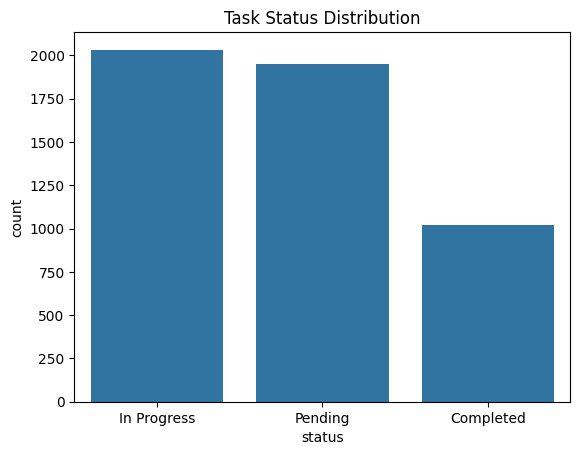

In [33]:
# Status distribution
sns.countplot(x='status', data=df)
plt.title("Task Status Distribution")
plt.show()


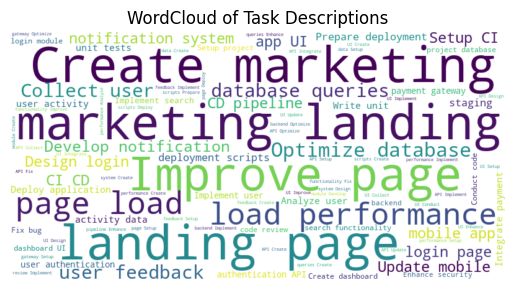

In [34]:
# Word Cloud of Task
text = " ".join(df['task_name'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Task Descriptions")
plt.show()

In [35]:
# -------------------------------
#  5. NLP Preprocessing
# -------------------------------
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()                           # lowercase
    text = re.sub(r'\d+', '', text)               # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()                         # tokenize
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['task_name'].astype(str).apply(preprocess_text)

print("\n NLP Preprocessing Completed!")
print(df[['task_name', 'clean_text']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\athul_dkx52yc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



 NLP Preprocessing Completed!
                           task_name                  clean_text
0      Create marketing landing page      creat market land page
1               Update mobile app UI          updat mobil app ui
2            Fix bug in login module         fix bug login modul
3  Implement user authentication API  implement user authent api
4      Improve page load performance    improv page load perform


In [36]:
# -------------------------------
#  6. Feature Extraction (TF-IDF)
# -------------------------------
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['clean_text']).toarray()

In [37]:
# -------------------------------
# 7. Task Classification (Naive Bayes)
# -------------------------------
y_task = df['task_name']
X_train, X_test, y_train, y_test = train_test_split(X, y_task, test_size=0.2, random_state=42)

In [38]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# Display key metrics
print("\n Naive Bayes Results:")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-Score :", f1_score(y_test, y_pred_nb, average='weighted'))


 Naive Bayes Results:
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-Score : 1.0


In [39]:
# SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Display key metrics
print("\n SVM Results:")
print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_svm, average='weighted'))
print("F1-Score :", f1_score(y_test, y_pred_svm, average='weighted'))


 SVM Results:
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-Score : 1.0


In [40]:
# -------------------------------
#  8. Priority Prediction (Random Forest & XGBoost)
# -------------------------------
from sklearn.preprocessing import LabelEncoder

if 'priority' in df.columns:
    y_priority = df['priority']

    # Encode string labels to numbers (e.g., High → 0, Medium → 1, Low → 2)
    le = LabelEncoder()
    y_priority_encoded = le.fit_transform(y_priority)

    X_priority = tfidf.fit_transform(df['clean_text']).toarray()

    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
        X_priority, y_priority_encoded, test_size=0.2, random_state=42
    )

In [41]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_p, y_train_p)
y_pred_rf = rf.predict(X_test_p)

# Display key metrics
print("\n Random Forest Results:")
print("Accuracy :", accuracy_score(y_test_p, y_pred_rf))
print("Precision:", precision_score(y_test_p, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_p, y_pred_rf, average='weighted'))
print("F1-Score :", f1_score(y_test_p, y_pred_rf, average='weighted'))


 Random Forest Results:
Accuracy : 0.507
Precision: 0.25704899999999997
Recall   : 0.507
F1-Score : 0.3411400132714001


In [42]:
# -------------------------------
# 9. Hyperparameter Tuning (GridSearchCV Example)
# -------------------------------
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [1000]
}
grid = GridSearchCV(LinearSVC(), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
print("\n Best SVM Params:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)


 Best SVM Params: {'C': 0.1, 'max_iter': 1000}
Best Accuracy: 1.0


In [43]:
# -------------------------------
# 10. Workload Balancing Logic (Example)
# -------------------------------
# Basic heuristic: Assign new tasks to the user with the least open tasks
if 'assigned_to' in df.columns and 'status' in df.columns:
    workload = df[df['status'] != 'Done']['assigned_to'].value_counts().to_dict()
    least_busy_user = min(workload, key=workload.get)
    print(f"\n Least Busy User (Suggested Assignment): {least_busy_user}")


 Least Busy User (Suggested Assignment): Alice


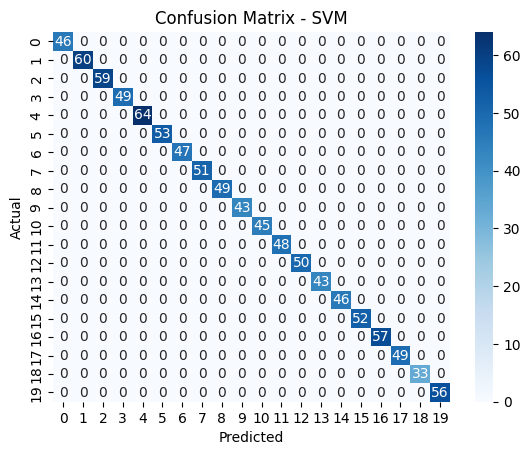

In [44]:
# -------------------------------
# 11. Visualization of Model Performance
# -------------------------------
conf_mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [49]:
# -------------------------------
# 12. Save Final Models (Optional)
# -------------------------------
import joblib
joblib.dump(nb_model, "naive_bayes_task_classifier.pkl")
joblib.dump(svm_model, "svm_task_classifier.pkl")
joblib.dump(rf, "random_forest_priority_model.pkl")
print("\n Models Saved Successfully!")


 Models Saved Successfully!


In [50]:
# -------------------------------
#  End of Training Pipeline
# -------------------------------
print("\n Project Training Completed Successfully!")


 Project Training Completed Successfully!


In [51]:
# -------------------------------
# 13. Test Predictions on New Data
# -------------------------------

# Example new task descriptions
new_tasks = [
    "Fix the bug in login authentication module",
    "Prepare project report for client meeting",
    "Update server configuration for better performance",
    "Design homepage UI for new product"
]

# Apply same preprocessing used during training
new_tasks_clean = [preprocess_text(task) for task in new_tasks]

# Transform using the same TF-IDF vectorizer
X_new = tfidf.transform(new_tasks_clean).toarray()

# ---- Predict Category / Task Type ----
print("\n Naive Bayes Predictions for Task Category/Priority:")
nb_predictions = nb_model.predict(X_new)
for task, pred in zip(new_tasks, nb_predictions):
    print(f" Task: {task}\n Predicted: {pred}\n")

# ---- Predict Priority (High/Medium/Low) using Random Forest ----
if 'priority' in df.columns:
    rf_predictions = rf.predict(X_new)
    rf_pred_labels = le.inverse_transform(rf_predictions)

    print("\n Random Forest Predictions for Task Priority:")
    for task, pred in zip(new_tasks, rf_pred_labels):
        print(f" Task: {task}\n Predicted Priority: {pred}\n")



 Naive Bayes Predictions for Task Category/Priority:
 Task: Fix the bug in login authentication module
 Predicted: Fix bug in login module

 Task: Prepare project report for client meeting
 Predicted: Setup project database

 Task: Update server configuration for better performance
 Predicted: Update mobile app UI

 Task: Design homepage UI for new product
 Predicted: Design login page


 Random Forest Predictions for Task Priority:
 Task: Fix the bug in login authentication module
 Predicted Priority: Medium

 Task: Prepare project report for client meeting
 Predicted Priority: Medium

 Task: Update server configuration for better performance
 Predicted Priority: Medium

 Task: Design homepage UI for new product
 Predicted Priority: Medium



In [54]:
# -------------------------------
# 14. Task Assignment Logic
# -------------------------------

# Filter only active tasks (not Done)
active_tasks = df[df['status'] != 'Done']

# Count how many tasks each user currently has
user_load = active_tasks['assigned_to'].value_counts()

print("\n Current Workload per User:")
print(user_load)

# Find least busy user
least_busy_user = user_load.idxmin()
print(f"\n Suggested User for Next Task: {least_busy_user}")

# Example new task
new_task = {
    "task_name": "Create marketing landing page",
    "priority": "Medium",
    "status": "To Do"
}

# Assign the new task automatically
new_task["assigned_to"] = least_busy_user

print("\n New Task Assigned:")
print(new_task)



 Current Workload per User:
assigned_to
Eve       667
Frank     650
David     632
Carol     624
Grace     621
Hannah    615
Bob       601
Alice     590
Name: count, dtype: int64

 Suggested User for Next Task: Alice

 New Task Assigned:
{'task_name': 'Create marketing landing page', 'priority': 'Medium', 'status': 'To Do', 'assigned_to': 'Alice'}
